# // **AI ROBOT SURFACE DETECTION** //

AI ROBOT SURFACE DETECTION is an entry to the <a href=”https://www.kaggle.com/”>kaggle</a> competition <a href=”https://www.kaggle.com/c/career-con-2019/overview”>Help Navigate Robots</a>. In the competition you help robots recognize the floor surface they moving across using only the Inertial Measurement Unit sensor data.  There are 9 types of floors including carpet, tiles, concrete, and others. 

This project is by Justin Snider and available on <a href="https://github.com/aobject/AI-ROBOT-SURFACE-DETECTION">GitHub here</a>. 

The competition description and datasets used are available on <a href=”https://www.kaggle.com/c/career-con-2019/overview”>Kaggel here</a>.

In this jupyter notebook I will walk you step by step through the process of loading the data, analyzing the data, creating the model, training the model, and evaluating the model's performance.  

# // **01 Setup** // 
## Import Libraries

In [1]:
# Standard libraries
import pandas as pd  # for data manipulation
import pickle
import numpy as np  # for better array operations 
import matplotlib.pyplot as plt  # plotting utilities 
import seaborn as sns  # for plotting data
from sklearn import preprocessing
import gc
# import scipy as sc 
import torch

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# pandas dislpay settings
pd.options.display.max_rows = 15
pd.options.display.max_columns = 999

## Load dataset to temp-data directory in Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pathlib import Path
import os
import requests
import pickle

In [5]:
os.chdir('/content/drive/My Drive')
print(os.getcwd())

# Move into primary Drive Folder
os.chdir('/content/drive/My Drive')

# Make temp-data directory and move inside
path_name = 'temp-data/'
Path("temp-data/").mkdir(parents=True, exist_ok=True)
os.chdir(path_name)
print('\nData directory created...')

urls = [('https://github.com/aobject/AI-ROBOT-SURFACE-DETECTION/blob/master/data/train_y.pkl.bz2?raw=true','train_y.pkl.bz2'),
        ('https://github.com/aobject/AI-ROBOT-SURFACE-DETECTION/blob/master/data/train_x.pkl.bz2?raw=true','train_x.pkl.bz2'),
        ('https://github.com/aobject/AI-ROBOT-SURFACE-DETECTION/blob/master/data/test_y.pkl.bz2?raw=true','test_y.pkl.bz2'),
        ('https://github.com/aobject/AI-ROBOT-SURFACE-DETECTION/blob/master/data/test_x.pkl.bz2?raw=true','test_x.pkl.bz2')]

def load_data(url, target_path):
  response = requests.get(url, stream=True)
  if response.status_code == 200:
      with open(target_path, 'wb') as f:
          f.write(response.raw.read())

print('Download starting...')

for i, (url,target_path) in enumerate(urls):
  load_data(url, target_path)

print('\nThe files in the data folder include:')
path = '.'
files = os.listdir(path)
for name in files:
    print(name)


train_y = pd.read_pickle('train_y.pkl.bz2')
print('\ntrain_y shape is {}'.format(train_y.shape))
train_x = pd.read_pickle('train_x.pkl.bz2')
print('train_x shape is {}'.format(train_x.shape))
test_y = pd.read_pickle('test_y.pkl.bz2')
print('test_y shape is {}'.format(test_y.shape))
test_x = pd.read_pickle('test_x.pkl.bz2')
print('test_x shape is {}'.format(test_x.shape))

print('\nAll done, your data is ready to go!!!\n')

/content/drive/My Drive

Data directory created...
Download starting...

The files in the data folder include:
train_y.pkl.bz2
train_x.pkl.bz2
test_y.pkl.bz2
test_x.pkl.bz2

train_y shape is (3790, 4)
train_x shape is (485120, 14)
test_y shape is (20, 4)
test_x shape is (2560, 14)

All done, your data is ready to go!!!



# // **01 Setup** // 
## Verify Data Is Loaded

In [24]:
# verify data is loaded 
train_x.head()

,Unnamed: 0,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,total_lin_acc
0,0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,10.005392
1,1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128,9.538638
2,2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,8.874697
3,3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,10.164638
4,4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,10.556132


In [25]:
test_x.head()

,Unnamed: 0,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,total_lin_acc
0,485120,3790_0,3790,0,0.70992,0.68801,0.10876,0.10405,-0.87528,0.138350,0.037472,-2.4550,-0.89309,-20.6040,20.768954
1,485121,3790_1,3790,1,0.70968,0.68818,0.10901,0.10429,-0.28090,0.046629,-0.225470,-9.9598,2.35790,-31.4030,33.028862
2,485122,3790_2,3790,2,0.70967,0.68836,0.10872,0.10348,0.63630,0.297700,-0.063138,9.2911,-0.23731,-29.5370,30.964742
3,485123,3790_3,3790,3,0.70975,0.68843,0.10819,0.10303,0.96157,0.106670,-0.127410,-12.8950,7.27000,1.6024,14.889648
4,485124,3790_4,3790,4,0.70968,0.68858,0.10784,0.10289,0.28418,-0.101810,-0.140990,13.9830,8.90370,13.2140,21.199291


In [26]:
train_y.head()

,Unnamed: 0,series_id,group_id,surface
0,0,0,13,fine_concrete
1,1,1,31,concrete
2,2,2,20,concrete
3,3,3,31,concrete
4,4,4,22,soft_tiles


In [27]:
test_y.head()

,Unnamed: 0,series_id,group_id,surface
0,3790,3790,59,hard_tiles_large_space
1,3791,3791,42,concrete
2,3792,3792,69,soft_pvc
3,3793,3793,55,tiled
4,3794,3794,40,hard_tiles_large_space


# // **02 Feature Engineering** // 
## **Questions to answer:** 
- What is the given data format? 
- What would be a good format for detecting patterns? 
- What patterns do we see in the data?

In [28]:
train_x.describe()

,Unnamed: 0,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,total_lin_acc
count,485120.000000,485120.00000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000,485120.000000
mean,242559.500000,1894.50000,63.500000,-0.017685,0.072816,0.012113,-0.003729,0.000157,0.008311,-0.019093,0.129337,2.886914,-9.364700,10.295712
std,140042.225631,1094.07985,36.949328,0.685940,0.708231,0.105991,0.104343,0.117179,0.088570,0.229038,1.863647,2.106743,2.824964,2.436978
min,0.000000,0.00000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-31.142000,-82.753000,-65.492000,0.492159
25%,121279.750000,947.00000,31.750000,-0.705120,-0.690450,-0.090101,-0.106060,-0.040682,-0.033161,-0.090624,-0.530030,1.959400,-10.191000,9.317014
50%,242559.500000,1894.50000,63.500000,-0.100910,0.235270,0.031747,-0.018173,0.000085,0.005402,-0.005314,0.124870,2.879900,-9.365100,9.927256
75%,363839.250000,2842.00000,95.250000,0.652380,0.805293,0.122560,0.097421,0.040446,0.047976,0.064601,0.791282,3.798400,-8.524300,10.859396
max,485119.000000,3789.00000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,55.948000,65.839000,106.120982


# // **02 Feature Engineering** // 
## **Stats**
- Number of sensor data chanels: 10
  - We have 10 different catagories of floating point sensor data to consider. 
- Size of each sequence to lable: 128
  - Each sequence that we need to label has 128 rows of data points for our 10 attributes. 
  - The values are sequential in time and represented by floating point values. 
  - We will need to consider how transform the real time data into inputs for our neural network. 
- Training set number of sequences: 3790
  - There are a total of 3790 sequences in the training data set. 
  - All sequences have a label provided to use for supervised learning. 


# // **02 Feature Engineering** // 
## What is the class distribution?

- Lets look at the percentage of the training set per class. 

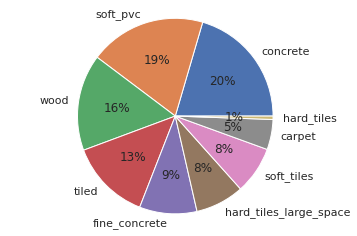

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.axes_style("darkgrid")

train_y.surface.count()

pd.DataFrame(train_y.surface.value_counts()).head(15)

lable_names = train_y.surface.value_counts().index.to_numpy()

lable_count = train_y.surface.value_counts().values

# plt.style.context('ggplot')
fig1, ax1 = plt.subplots()
ax1.pie(lable_count, labels=lable_names, autopct='%1.f%%')
ax1.axis('equal')
plt.show()




In [12]:
pd.DataFrame(train_y.surface.value_counts()).head(15)

,surface
concrete,776
soft_pvc,730
wood,604
tiled,508
fine_concrete,360
hard_tiles_large_space,305
soft_tiles,297
carpet,189
hard_tiles,21


# // **02 Feature Engineering** // 
## Discoveries: 

- Concrete and soft_pvc occure most often in the training set.
- Very few hard_tile sequences occur, only 21

# // **02 Feature Engineering** // 
## What are the characteristics of the features? 

## Lets get the following list of stats for **EACH** attribute of **EACH** sequence including:
- mean
- median
- standard deviation
- minimum value
- maximum value
- range


In [13]:
# train_x add new stats for groups 


def get_stats(data_x, test_data_x):
  result = pd.DataFrame()
  test_result = pd.DataFrame()

  data_x['total_lin_acc'] = (data_x['linear_acceleration_X']**2 + data_x['linear_acceleration_Y']**2 + data_x['linear_acceleration_Z']**2)**0.5
  test_data_x['total_lin_acc'] = (test_data_x['linear_acceleration_X']**2 + test_data_x['linear_acceleration_Y']**2 + test_data_x['linear_acceleration_Z']**2)**0.5
  print('Our list of attributes is: ')
  for item in data_x.columns:
    if item in data_x.columns[:3]:
      continue
    print(item)  
  
    result[item + '_mean'] = data_x.groupby(['series_id'])[item].mean()
    result[item + '_median'] = data_x.groupby(['series_id'])[item].median()
    result[item + '_std'] = data_x.groupby(['series_id'])[item].std()
    result[item + '_min'] = data_x.groupby(['series_id'])[item].min()
    result[item + '_max'] = data_x.groupby(['series_id'])[item].max()
    result[item + '_range'] = result[item + '_max'] - result[item + '_min']

    test_result[item + '_mean'] = test_data_x.groupby(['series_id'])[item].mean()
    test_result[item + '_median'] = test_data_x.groupby(['series_id'])[item].median()
    test_result[item + '_std'] = test_data_x.groupby(['series_id'])[item].std()
    test_result[item + '_min'] = test_data_x.groupby(['series_id'])[item].min()
    test_result[item + '_max'] = test_data_x.groupby(['series_id'])[item].max()
    test_result[item + '_range'] = test_result[item + '_max'] - test_result[item + '_min']

  return result, test_result

sequence_stats, test_stats = get_stats(train_x, test_x)
test_stats.head()

Our list of attributes is: 
measurement_number
orientation_X
orientation_Y
orientation_Z
orientation_W
angular_velocity_X
angular_velocity_Y
angular_velocity_Z
linear_acceleration_X
linear_acceleration_Y
linear_acceleration_Z
total_lin_acc


,measurement_number_mean,measurement_number_median,measurement_number_std,measurement_number_min,measurement_number_max,measurement_number_range,orientation_X_mean,orientation_X_median,orientation_X_std,orientation_X_min,orientation_X_max,orientation_X_range,orientation_Y_mean,orientation_Y_median,orientation_Y_std,orientation_Y_min,orientation_Y_max,orientation_Y_range,orientation_Z_mean,orientation_Z_median,orientation_Z_std,orientation_Z_min,orientation_Z_max,orientation_Z_range,orientation_W_mean,orientation_W_median,orientation_W_std,orientation_W_min,orientation_W_max,orientation_W_range,angular_velocity_X_mean,angular_velocity_X_median,angular_velocity_X_std,angular_velocity_X_min,angular_velocity_X_max,angular_velocity_X_range,angular_velocity_Y_mean,angular_velocity_Y_median,angular_velocity_Y_std,angular_velocity_Y_min,angular_velocity_Y_max,angular_velocity_Y_range,angular_velocity_Z_mean,angular_velocity_Z_median,angular_velocity_Z_std,angular_velocity_Z_min,angular_velocity_Z_max,angular_velocity_Z_range,linear_acceleration_X_mean,linear_acceleration_X_median,linear_acceleration_X_std,linear_acceleration_X_min,linear_acceleration_X_max,linear_acceleration_X_range,linear_acceleration_Y_mean,linear_acceleration_Y_median,linear_acceleration_Y_std,linear_acceleration_Y_min,linear_acceleration_Y_max,linear_acceleration_Y_range,linear_acceleration_Z_mean,linear_acceleration_Z_median,linear_acceleration_Z_std,linear_acceleration_Z_min,linear_acceleration_Z_max,linear_acceleration_Z_range,total_lin_acc_mean,total_lin_acc_median,total_lin_acc_std,total_lin_acc_min,total_lin_acc_max,total_lin_acc_range
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3790,63.5,63.5,37.094474,0,127,127,0.710416,0.710435,0.000525,0.70935,0.71142,0.00207,0.687769,0.687775,0.000523,0.68675,0.68865,0.00190,0.107808,0.107775,0.000706,0.105830,0.109680,0.003850,0.103248,0.103300,0.000550,0.101390,0.104500,0.003110,-0.002570,0.005933,0.404307,-0.87853,0.96258,1.84111,-0.000699,-0.003197,0.123289,-0.267960,0.368400,0.636360,0.003400,0.010132,0.102856,-0.225470,0.246430,0.471900,0.290920,-0.036063,4.455253,-12.89500,13.9830,26.87800,2.975297,3.11050,3.126508,-8.1074,11.2200,19.3274,-9.512869,-9.64610,9.751866,-31.711,16.6750,48.3860,13.296905,11.402018,6.836518,2.890788,33.028862,30.138074
3791,63.5,63.5,37.094474,0,127,127,0.804211,0.803990,0.000996,0.80275,0.80611,0.00336,-0.574625,-0.574055,0.001544,-0.57763,-0.57208,0.00555,-0.083750,-0.083600,0.002116,-0.089394,-0.080153,0.009241,0.126576,0.126720,0.002770,0.119800,0.132450,0.012650,0.026381,-0.000472,0.542410,-1.69460,1.70320,3.39780,-0.005137,0.007264,0.207544,-0.798100,0.632480,1.430580,0.035325,0.026245,0.154303,-0.427550,0.454590,0.882140,0.029406,0.432630,9.136620,-36.06700,33.0850,69.15200,2.302994,2.95435,23.201073,-121.4900,73.0080,194.4980,-9.383124,-9.30935,17.779225,-75.386,55.7660,131.1520,22.903142,12.192883,22.433611,3.430561,139.704969,136.274408
3792,63.5,63.5,37.094474,0,127,127,0.640428,0.640285,0.001154,0.63847,0.64262,0.00415,-0.759004,-0.758990,0.000958,-0.76053,-0.75698,0.00355,-0.083907,-0.084093,0.000660,-0.085034,-0.082573,0.002461,0.081981,0.081959,0.000532,0.081091,0.083147,0.002056,-0.001616,0.004255,0.062913,-0.16776,0.11142,0.27918,0.015782,0.015759,0.014118,-0.022201,0.053108,0.075309,-0.034910,-0.036681,0.019260,-0.082789,0.012100,0.094889,0.049342,0.063321,0.436392,-0.93724,1.0968,2.03404,2.046837,2.18395,1.630881,-1.9501,5.0369,6.9870,-9.545461,-9.47575,0.737822,-12.012,-8.0521,3.9599,9.906969,9.988305,0.729378,8.062241,12.120578,4.058337
3793,63.5,63.5,37.094474,0,127,127,-0.977197,-0.977295,0.000703,-0.97818,-0.97569,0.00249,0.151184,0.150595,0.004542,0.14477,0.15962,0.01485,0.017485,0.017457,0.000591,0.016662,0.018742,0.002080,-0.147992,-0.148035,0.000467,-0.148990,-0.147190,0.001800,0.005635,0.008498,0.084345,-0.18546,0.24806,0.43352,0.029031,0.031111,0.043922,-0.073905,0.179970,0.253875,-0.093127,-0.086524,0.037353,-0.18221

# // **02 Feature Engineering** // 
## We now have a set of stats based on our sequences we can use for the input of our neural network! 
## What are the characteristics of the sequence stats by **grouped** by **matterial class**? 

In [14]:
def get_material_stats(data_x,data_y):
  result = pd.DataFrame()

  temp_join = data_x.merge(data_y, on='series_id', how='inner')
  
  classes = (data_y['surface'].value_counts()).index

  print('Our material classes include: ')
  for item in classes:
    print(item)
    # result['surface'] = item
    # result['group_id'] = data_y.groupby(['surface'])['surface'==item,1]
    # print('surface type {} has group_id {}'.format(item, result['group_id']))
    for feature in data_x.columns:
      result[feature + '_mat_mean'] = temp_join.groupby(['surface'])[feature].mean()
      result[feature + '_mat_median'] = temp_join.groupby(['surface'])[feature].mean()
      result[feature + '_mat_std'] = temp_join.groupby(['surface'])[feature].std()
      result[feature + '_mat_min'] = temp_join.groupby(['surface'])[feature].min()
      result[feature + '_mat_max'] = temp_join.groupby(['surface'])[feature].max()
      result[feature + '_mat_range'] = result[feature + '_mat_max'] - result[feature + '_mat_min']
  return result


mat_stats = get_material_stats(sequence_stats,train_y)
mat_stats.head(10)
# mat_stats.shape()
# print(get_material_stats(get_stats(train_x),train_y))

Our material classes include: 
concrete
soft_pvc
wood
tiled
fine_concrete
hard_tiles_large_space
soft_tiles
carpet
hard_tiles


,measurement_number_mean_mat_mean,measurement_number_mean_mat_median,measurement_number_mean_mat_std,measurement_number_mean_mat_min,measurement_number_mean_mat_max,measurement_number_mean_mat_range,measurement_number_median_mat_mean,measurement_number_median_mat_median,measurement_number_median_mat_std,measurement_number_median_mat_min,measurement_number_median_mat_max,measurement_number_median_mat_range,measurement_number_std_mat_mean,measurement_number_std_mat_median,measurement_number_std_mat_std,measurement_number_std_mat_min,measurement_number_std_mat_max,measurement_number_std_mat_range,measurement_number_min_mat_mean,measurement_number_min_mat_median,measurement_number_min_mat_std,measurement_number_min_mat_min,measurement_number_min_mat_max,measurement_number_min_mat_range,measurement_number_max_mat_mean,measurement_number_max_mat_median,measurement_number_max_mat_std,measurement_number_max_mat_min,measurement_number_max_mat_max,measurement_number_max_mat_range,measurement_number_range_mat_mean,measurement_number_range_mat_median,measurement_number_range_mat_std,measurement_number_range_mat_min,measurement_number_range_mat_max,measurement_number_range_mat_range,orientation_X_mean_mat_mean,orientation_X_mean_mat_median,orientation_X_mean_mat_std,orientation_X_mean_mat_min,orientation_X_mean_mat_max,orientation_X_mean_mat_range,orientation_X_median_mat_mean,orientation_X_median_mat_median,orientation_X_median_mat_std,orientation_X_median_mat_min,orientation_X_median_mat_max,orientation_X_median_mat_range,orientation_X_std_mat_mean,orientation_X_std_mat_median,orientation_X_std_mat_std,orientation_X_std_mat_min,orientation_X_std_mat_max,orientation_X_std_mat_range,orientation_X_min_mat_mean,orientation_X_min_mat_median,orientation_X_min_mat_std,orientation_X_min_mat_min,orientation_X_min_mat_max,orientation_X_min_mat_range,orientation_X_max_mat_mean,orientation_X_max_mat_median,orientation_X_max_mat_std,orientation_X_max_mat_min,orientation_X_max_mat_max,orientation_X_max_mat_range,orientation_X_range_mat_mean,orientation_X_range_mat_median,orientation_X_range_mat_std,orientation_X_range_mat_min,orientation_X_range_mat_max,orientation_X_range_mat_range,orientation_Y_mean_mat_mean,orientation_Y_mean_mat_median,orientation_Y_mean_mat_std,orientation_Y_mean_mat_min,orientation_Y_mean_mat_max,orientation_Y_mean_mat_range,orientation_Y_median_mat_mean,orientation_Y_median_mat_median,orientation_Y_median_mat_std,orientation_Y_median_mat_min,orientation_Y_median_mat_max,orientation_Y_median_mat_range,orientation_Y_std_mat_mean,orientation_Y_std_mat_median,orientation_Y_std_mat_std,orientation_Y_std_mat_min,orientation_Y_std_mat_max,orientation_Y_std_mat_range,orientation_Y_min_mat_mean,orientation_Y_min_mat_median,orientation_Y_min_mat_std,orientation_Y_min_mat_min,orientation_Y_min_mat_max,orientation_Y_min_mat_range,orientation_Y_max_mat_mean,orientation_Y_max_mat_median,orientation_Y_max_mat_std,orientation_Y_max_mat_min,orientation_Y_max_mat_max,orientation_Y_max_mat_range,orientation_Y_range_mat_mean,orientation_Y_range_mat_median,orientation_Y_range_mat_std,orientation_Y_range_mat_min,orientation_Y_range_mat_max,orientation_Y_range_mat_range,orientation_Z_mean_mat_mean,orientation_Z_mean_mat_median,orientation_Z_mean_mat_std,orientation_Z_mean_mat_min,orientation_Z_mean_mat_max,orientation_Z_mean_mat_range,orientation_Z_median_mat_mean,orientation_Z_median_mat_median,orientation_Z_median_mat_std,orientation_Z_median_mat_min,orientation_Z_median_mat_max,orientation_Z_median_mat_range,orientation_Z_std_mat_mean,orientation_Z_std_mat_median,orientation_Z_std_mat_std,orientation_Z_std_mat_min,orientation_Z_std_mat_max,orientation_Z_std_mat_range,orientation_Z_min_mat_mean,orientation_Z_min_mat_median,orientation_Z_min_mat_std,orientation_Z_min_mat_min,orientation_Z_min_mat_max,orientation_Z_min_mat_range,orientation_Z_max_mat_mean,orientation_Z_max_mat_median,orientation_Z_max_mat_std,orientation_Z_max_mat_min,orientation_Z_m

# // **02 Feature Engineering** // 
## Create index values to be used to identify materials by integer
- We will need to have integers to represent our matterials
- Here we create a dictionary that can be used to convert from string to integer and another that converts from integer to string. 

In [15]:
# create index values to be used to identify materials

material_set = set(train_y.surface.unique())

material_to_index = dict()
index_to_material = dict()
# for index, row in train_y.iterrows

# print(material_set)

i = 0 
for item in material_set:
  material_to_index[item] = i
  index_to_material[i] = item
  i += 1

# print(material_to_index) 
# print(index_to_material)

train_y_index = []
for index, row in train_y.iterrows():
  train_y_index.append(material_to_index[row['surface']])

train_y_index = np.array(train_y_index)

test_y_index = []
for index, row in test_y.iterrows():
  test_y_index.append(material_to_index[row['surface']])

test_y_index = np.array(test_y_index)
print(material_to_index)

{'carpet': 0, 'concrete': 1, 'soft_pvc': 2, 'hard_tiles_large_space': 3, 'fine_concrete': 4, 'wood': 5, 'soft_tiles': 6, 'hard_tiles': 7, 'tiled': 8}


# // **02 Feature Engineering** // 
## How do the distributions compare when divided up by material class? 
- To predict the class we will need to find patterns in the data. 
- Here we plot the values for all attributes as a single plot. 
- We have 66 statistics, so there are 66 plots. 
- For the attribute we put the data side by side for each of our materials. 

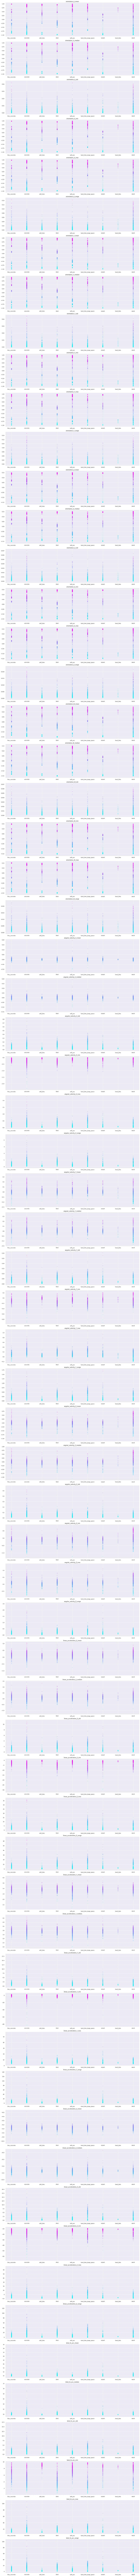

In [16]:
# The ``inline`` flag will use the appropriate backend to make figures appear inline in the notebook.  
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

cmap = "cool"

count = 1
plt.figure(figsize=( 18, len(sequence_stats.columns)*5 ))

for column in sequence_stats.columns[6:]:
  y = sequence_stats[column].values.tolist()
  x = train_y.surface.values
  plt.subplot(len(sequence_stats.columns), 1, count)
  plt.scatter(x,y, c=y, cmap=cmap, alpha=0.1)
  plt.title(column)
  count += 1

plt.tight_layout()
plt.show()

# // **02 Feature Engineering** // 
## What did we learn? 
- There are distinct distributions visible when comparing our stats between materials for all of our attributes. 
- The large number of attributes suggests we need to use a method with gradient descent, rather than a closed form normal equation. 
- The complex overlap between values in the set suggests we will need a complex model rather than a simple one. A nerual network would be a good direction to go.  

# // **02 Feature Engineering** // 
##Scale Data for input to network

In [17]:
# scale all values to 0.01 - 1.0 range 

scaler = preprocessing.StandardScaler().fit(sequence_stats.values)  # get data scale fit object
scale_seq_stats = pd.DataFrame(scaler.transform(sequence_stats.values), index=sequence_stats.index, columns=sequence_stats.columns)  # scale training data and center on mean
scale_test_stats = pd.DataFrame(scaler.transform(test_stats.values), index=test_stats.index, columns=test_stats.columns)   # scale test data and center on mean (using fit to training data)

print(scale_seq_stats.shape)
print(scale_test_stats.shape)
scale_test_stats.head()

(3790, 72)
(20, 72)


,measurement_number_mean,measurement_number_median,measurement_number_std,measurement_number_min,measurement_number_max,measurement_number_range,orientation_X_mean,orientation_X_median,orientation_X_std,orientation_X_min,orientation_X_max,orientation_X_range,orientation_Y_mean,orientation_Y_median,orientation_Y_std,orientation_Y_min,orientation_Y_max,orientation_Y_range,orientation_Z_mean,orientation_Z_median,orientation_Z_std,orientation_Z_min,orientation_Z_max,orientation_Z_range,orientation_W_mean,orientation_W_median,orientation_W_std,orientation_W_min,orientation_W_max,orientation_W_range,angular_velocity_X_mean,angular_velocity_X_median,angular_velocity_X_std,angular_velocity_X_min,angular_velocity_X_max,angular_velocity_X_range,angular_velocity_Y_mean,angular_velocity_Y_median,angular_velocity_Y_std,angular_velocity_Y_min,angular_velocity_Y_max,angular_velocity_Y_range,angular_velocity_Z_mean,angular_velocity_Z_median,angular_velocity_Z_std,angular_velocity_Z_min,angular_velocity_Z_max,angular_velocity_Z_range,linear_acceleration_X_mean,linear_acceleration_X_median,linear_acceleration_X_std,linear_acceleration_X_min,linear_acceleration_X_max,linear_acceleration_X_range,linear_acceleration_Y_mean,linear_acceleration_Y_median,linear_acceleration_Y_std,linear_acceleration_Y_min,linear_acceleration_Y_max,linear_acceleration_Y_range,linear_acceleration_Z_mean,linear_acceleration_Z_median,linear_acceleration_Z_std,linear_acceleration_Z_min,linear_acceleration_Z_max,linear_acceleration_Z_range,total_lin_acc_mean,total_lin_acc_median,total_lin_acc_std,total_lin_acc_min,total_lin_acc_max,total_lin_acc_range
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3790,0.0,0.0,1.0,0.0,0.0,0.0,1.061531,1.061490,-0.576085,1.070991,1.051959,-0.563901,0.868340,0.868300,-0.556786,0.875817,0.860644,-0.552461,0.902934,0.902614,-0.203432,0.899121,0.905479,0.191052,1.025331,1.025784,-0.398465,1.023594,1.021013,-0.083968,-0.262562,0.448697,4.204958,-3.146705,3.517251,3.381934,-0.132355,-0.170286,2.344714,-1.265722,1.976920,2.027272,0.102852,0.132948,1.152647,-0.393500,0.647605,1.342769,0.855175,-0.710161,2.568404,-2.644562,2.754742,2.773005,0.356860,0.675137,1.157306,-1.566783,1.216388,1.462132,-1.836384,-1.810004,4.075577,-2.774950,3.588781,3.220398,3.765628,2.221858,3.457248,-1.476659,2.607478,2.435428
3791,0.0,0.0,1.0,0.0,0.0,0.0,1.198280,1.197880,-0.501958,1.207238,1.189933,-0.504461,-0.914216,-0.913369,-0.390855,-0.908305,-0.920769,-0.378457,-0.904509,-0.903045,1.349755,-0.941838,-0.886211,1.936226,1.248922,1.250255,1.991124,1.200020,1.288853,2.931972,2.524538,-0.039068,6.054330,-7.098783,7.078499,7.193460,-0.197553,-0.016979,4.917881,-5.650742,4.186221,6.162873,0.248834,0.206494,2.332887,-1.241053,1.527156,3.572169,-0.528882,1.335265,6.564547,-9.329530,8.052998,8.910952,-2.357683,0.212067,17.462883,-27.920140,19.066347,24.849166,-0.228350,0.283643,8.368382,-10.236712,10.545756,10.541403,15.818673,3.630706,14.150647,-1.239650,18.935153,15.107110
3792,0.0,0.0,1.0,0.0,0.0,0.0,0.959492,0.959222,-0.477246,0.967595,0.951710,-0.468060,-1.174568,-1.174492,-0.486024,-1.166388,-1.182033,-0.473802,-0.905993,-0.907692,-0.253842,-0.900723,-0.909052,-0.258595,0.821492,0.821234,-0.418706,0.829066,0.816391,-0.417176,-0.170740,0.320929,-0.366723,0.295425,-0.575526,-0.442423,0.109748,0.107533,-0.989358,0.767059,-0.660821,-0.894191,-0.072325,-0.080733,-0.765132,0.204924,-0.342522,-0.706052,-0.423372,-0.276441,-0.862206,0.805173,-0.819459,-0.834197,-3.391964,-2.072587,-0.057517,-0.135650,-0.569850,-0.185436,-2.240323,-0.750901,-0.744880,0.590574,-0.811869,-0.709279,-0.487760,-0.296530,-0.729819,0.794080,-0.592711,-0.678247
3793,0.0,0.0,1.0,0.0,0.0,0.0,-1.398915,-1.398972,-0.548022,-1.390692,-1.406355,-0.544548,0.110659,0.109817,0.096832,0.111048,0.113124,0.064895,0.050688,0.050447,-0.330383,0.058268,0.047184,-0.381932,-1.382695,-1.383164,-0.488402,-1.375838,-1.390889,-0.498107,0.527314,0.644041,-0.079719,0.209707,0.081503,-0.064

# // **03 Create Neural Network** // 
## Create DataSet and Data Loader
- Choose cuda gpu if available to speed up calculations
- Create tensors to hold X and y data 
- Place tensors into dataset objects
- Place dataset objects into subset objects
- Use subset objects to create dataloader objects with batch size of 100

In [0]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
import math
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_tensor = torch.from_numpy(scale_seq_stats.to_numpy()).float().to(device)
test_x_tensor = torch.from_numpy(scale_test_stats.to_numpy()).float().to(device)

y_tensor = torch.from_numpy(train_y_index).long().to(device)
test_y_tensor = torch.from_numpy(test_y_index).long().to(device)

dataset = TensorDataset(x_tensor, y_tensor) 
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

sub_dataset = Subset(dataset, np.arange(0,len(dataset),1))
sub_test_dataset = Subset(test_dataset, np.arange(0,len(test_dataset),1))


train_size = math.floor(len(train_y) * 0.8) 
test_size = len(train_y) - train_size

size_of_batch = 100
train_loader = DataLoader(dataset=sub_dataset, batch_size=size_of_batch)
val_loader = DataLoader(dataset=sub_test_dataset, batch_size=size_of_batch)


# // **03 Create Neural Network** // 
## Create Neural Network Class
- Create input layer to hold our 72 values
- Create 2 sets of hidden layers
- Create ouput to 9 classes in our final layer 
- Use the linear type layer since we have distinct statistics that do not have time based relationships to scan for. 
- We use the rectified linear activation function. 
- We use softmax to output our final estimated probability helping us to decide our classification.  

In [0]:
# Input Layer Nodes: 42 (the number of normalized statistics we have for each sequence)
# Hidden Layer 40 Nodes (arbitrary) (ReLu)
# Hidden layer 40 Nodes (arbitrary) (ReLu)
# Output Layer Nodes: 9 (9 surfaces to classify) (LogSoftmax)

class NeuralNetwork(nn.Module):
  def __init__(self):  # initialization of class
    super().__init__()  # initialize parent class
    self.fc1 = nn.Linear(72, 72)  # create initional weights for input nodes to hidden layer 1 nodes
    self.fc2 = nn.Linear(72, 40)  # create initional weights for hidden layer 1 nodes to hidden layer 2
    self.fc3 = nn.Linear(40, 40)  # create initional weights for hidden layer 1 nodes to hidden layer 2
    self.fc4 = nn.Linear(40, 9)   # create initional weights for hidden layer 2, to output nodes 

  def forward(self, x):  # define the model structure, components, and order of the different layers
    # import pdb; pdb.set_trace()
    x = x.view(x.shape[0], -1) # format input data to be a vector in the same shape as example  

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    x = F.log_softmax(x, dim=1)

    return x


model = NeuralNetwork().to(device)

# // **03 Create Neural Network** // 
##Helper function to score the number of correct predictions.

In [0]:
def get_max_index(in_guess, in_target):
  resulta, resultb = np.unravel_index(np.argmax(in_guess, axis=1), in_guess.shape)
  result = np.equal(resultb,in_target)
  # take sum of result and return 
  return np.equal(resultb,in_target).astype(int).sum()
      

##Helper function to display a progress bar while the network is training. 

In [0]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


# // **04 Train the Neural Network** // 
## Train the network
- We use the Negative Log Likelihood Loss function
- We set the number of epochs
  - The number of epochs was optimed by running the training with many different values to find the value that gives the lowest test error rate
- We set the learning rate
  - The learning rate is optimized by training with many different values to find the value that gives the lowest test error rate. 
- We track both the loss rate and the correct prediction rate over the epochs

In [22]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.012)

num_epochs = 200

losses = []
val_losses = []
train_losses = []
arr_train_loss = []
arr_train_correct = []
arr_test_loss = []
arr_test_correct = []
min_test_loss_index = 0
out = display(progress(0, num_epochs - 1), display_id=True)

for i in range(num_epochs):
  out.update(progress(i, num_epochs - 1))
  cum_train_loss = 0  # keep track of total loss over epoch
  cum_test_loss = 0
  batch_num = 0 
  arr_batch_num = []
  batch_losses = []
  count_train = 0 
  arr_count_train = []
  count_val = 0
  arr_count_val = []
  training_wins = 0
  validation_wins = 0
  result_stats = []

  # loop through data in batch
  for batch, labels in train_loader:  # declare test data with data and label pairs
    batch = batch.to(device)
    labels = labels.to(device)
    model.train()
    output = model(batch)  # run a forward pass of data through network and get prediction
    training_wins += get_max_index((output.cpu().detach().numpy()),( labels.cpu().detach().numpy()))
    loss = criterion(output, labels.squeeze())  # calculate the loss between the prediction and expected value
    loss.backward()
    optimizer.step()  # update weights of neural network using loss 
    optimizer.zero_grad()  # zero out gradients at the start of each epoch
    cum_train_loss += loss.item()
    count_train += len(labels) 

  with torch.no_grad():
    for x_val, y_val in val_loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      model.eval()
      output = model(x_val)
      validation_wins += get_max_index((output.cpu().numpy()), (y_val.cpu().numpy()))
      loss = criterion(output, y_val.squeeze())
      cum_test_loss += loss.item()
      count_val += len(y_val) 
  arr_train_loss.append((cum_train_loss / count_train * 100))
  arr_train_correct.append((training_wins / count_train * 100))
  arr_test_loss.append((cum_test_loss / count_val * 100))
  arr_test_correct.append((validation_wins / count_val * 100))




# // **05 Visualize the Results** // 
## Now we are done training. Lets plot the results! 

Epoch with lowest test loss: 199
Number or Epochs: 200
Training Loss: 0.5695125680800164%
Test Loss: 2.34587162733078%
Training Correct Percentage 80.97625329815304%
Test Correct Percentage 95.0%


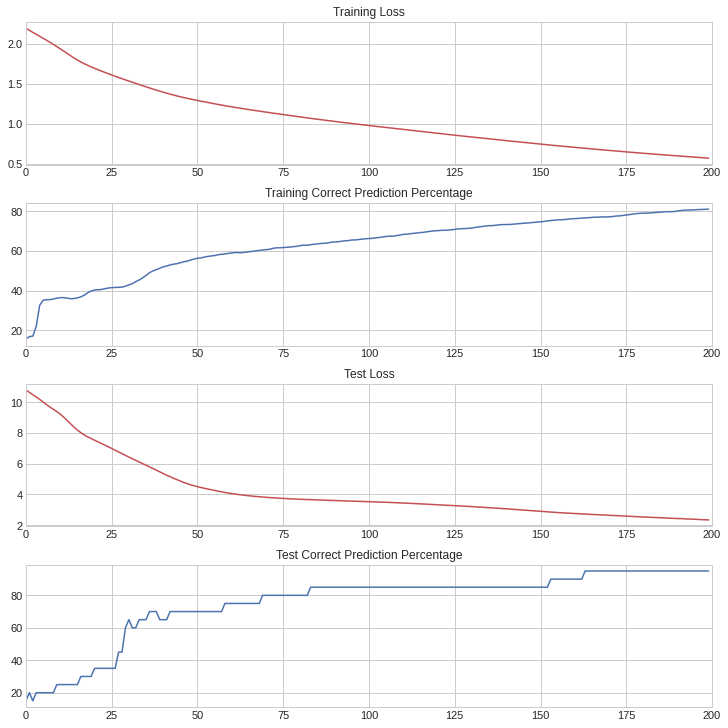

In [23]:
plt.style.use('seaborn-whitegrid')

x = np.linspace(0, num_epochs, num_epochs, endpoint=False, dtype=int)

fig, axes = plt.subplots(4, figsize=(10,10), constrained_layout=True)
axes[0].plot(x, arr_train_loss, color='r')
axes[0].set(xlim=(0, num_epochs))
axes[0].set_title('Training Loss')

axes[1].plot(x, arr_train_correct)
axes[1].set(xlim=(0, num_epochs))
axes[1].set_title('Training Correct Prediction Percentage')

axes[2].plot(x, arr_test_loss,  color='r')
axes[2].set(xlim=(0, num_epochs))
axes[2].set_title('Test Loss')

axes[3].plot(x, arr_test_correct)
axes[3].set(xlim=(0, num_epochs))
axes[3].set_title('Test Correct Prediction Percentage')

best_epoch = (np.unravel_index(np.argmin(arr_test_loss,axis=None),np.array(arr_test_loss).shape))[0]
print('Epoch with lowest test loss: {}'.format(best_epoch))
print('Number or Epochs: {}'.format(num_epochs))

print('Training Loss: {}%'.format(arr_train_loss[-1]))
print('Test Loss: {}%'.format(arr_test_loss[-1]))
print('Training Correct Percentage {}%'.format(arr_train_correct[-1]))
print('Test Correct Percentage {}%'.format(arr_test_correct[-1]))


# // **06 Conclusions** // 
## Settings: 
- Epochs: 200 
  - If we increase the number the model is over trained. The predictions become very bad for any new data. 
  - If we decrease the number the model does not reach the high point of 95% correct predictions. 
- Learning Rate: 0.012
  - The learning rate is very important. With a value of 0.012 we are able to get 95% correct predictions. However, anything larger or smaller will peak at a lower correct prediction rate. 
  - Using typical values and a neural network with less layers and less nodes we originally had a prediction rate of about 80%. We are able to increase this prediction rate to 95% by optimizing the settings. 

## Data: 
- Using the orginal data with no abstracted stats gave a prediction rate of around 50% correct. 
- Using instead the stats we abstracted from the raw sequence data boosted our test prediction rate from around 50% up to around 80%. 

## Reasons to use a Neural Network Model: 
- There are distinct distributions visible when comparing our stats between materials for all of our attributes.
- However, the large number of attributes suggests we need to use a method with gradient descent, rather than a closed form normal equation.
- The complex overlap between values in the set suggests we will need a realatively complex model rather than a simple one. A nerual network would be a good direction to go.

## Neural Network Design:
- We use softmax to output our final estimated probability helping us to decide our classification.
- We use the Negative Log Likelihood Loss function
- Use the linear type layer since we have distinct statistics that do not have time based relationships to scan for.
- We use the rectified linear activation function.


## Neural Network: 
- Much of the neural network is standard based on our number of inputs, type of data, and 9 class mutually exclusive classification output. 
- We made a few changes that improved the prediction rate.
  - We increased the number of hidden layers from 1 to 2. 
  - Adding 3 or 4 middle layers resulted in overfitting the model so we went back to 2. 
  - We increased the number of nodes on the hidden layers. 
  - Increasing the nodes to the maximum number possible resulted in overfitting so we went back to the current settings. 
- Together with improving the settings (such as learning rate and epoch count) the updated neural network improved prediction rates on the test set from 80% to 95%. 

# // **The End** // 